#*Deep Learning Project - Texture synthesis through diffusion models*

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
import torchvision
from PIL import Image
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import copy

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print("Current device:", device)
if torch.cuda.is_available():
  print(" Type:", torch.cuda.get_device_name(0))

Current device: cuda
 Type: Tesla T4


In [ ]:
from google.colab import drive
GDRIVE_DIR = "/content/drive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "/MyDrive/DL Project - Texture synthesis"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/Dataset"
GDRIVE_MODEL_DIR = GDRIVE_HOME_DIR + '/Validation'

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/drive


In [ ]:
class ColorectalHistologyDataset(Dataset):
    def __init__(self,  img_dir, img_size, max_items=5010):
        #transform = transforms.Compose([transforms.PILToTensor(), transforms.Lambda(lambda t: t.permute(2,0,1))])
        transform = transforms.Compose([transforms.Resize(80),  # image_size + 1/4 *args.image_size
                                        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.classes = {f: int(f[1])-1 for f in os.listdir(img_dir)}
        self.images = []
        self.labels = []
        for dir in self.classes.keys():
            dir_class = os.path.join(img_dir,dir)
            label = self.classes[dir]
            for image in os.listdir(dir_class):
                im = Image.open(os.path.join(dir_class, image))
                im = transform(im).float()
                self.images.append(im)
                self.labels.append(label)

        self.images = self.images[:max_items]
        self.labels = self.labels[:max_items]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


In [ ]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()

def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

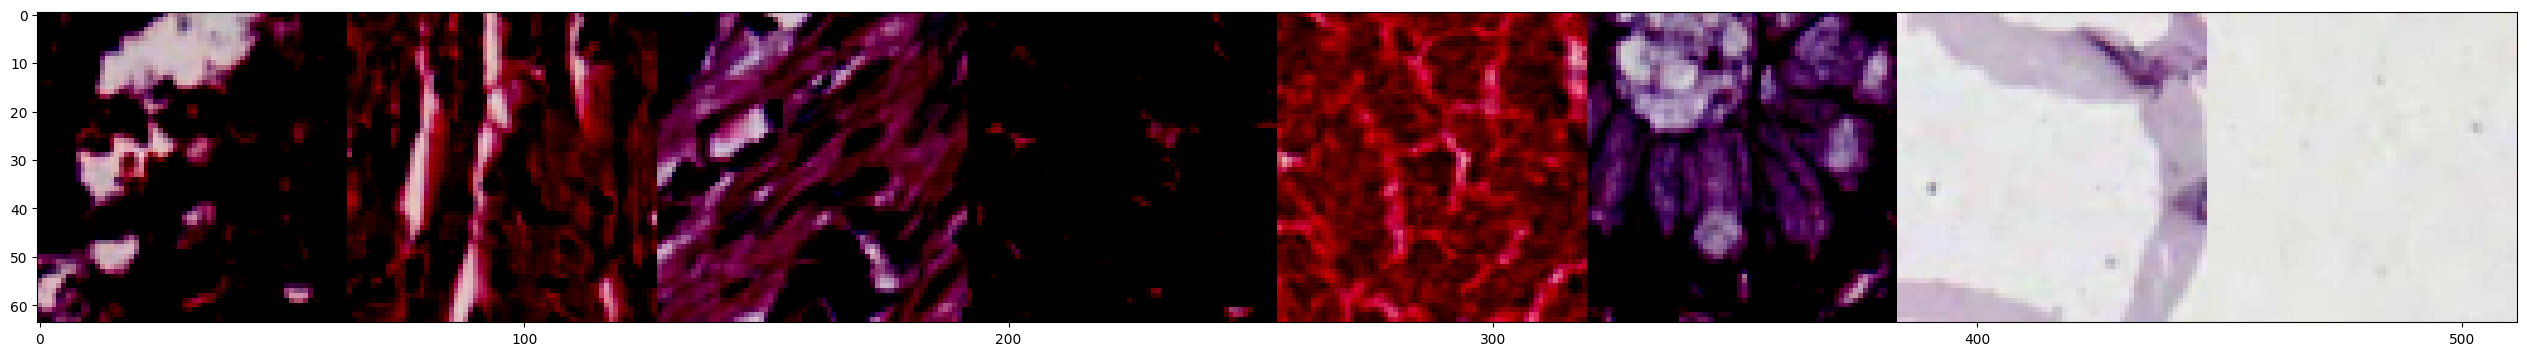

In [ ]:
dataset = ColorectalHistologyDataset(f'{GDRIVE_DATA_DIR}/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000', 64)
indexes = []
for i in range(8):
  indexes.append(dataset.labels.index(i)+5)
images = [dataset[i][0] for i in indexes]
plot_images(torch.stack(images, dim=0))

##*Model architecture*

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes=None, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64).to(device)
        self.down1 = Down(64, 128).to(device)
        self.sa1 = SelfAttention(128, 32).to(device)
        self.down2 = Down(128, 256).to(device)
        self.sa2 = SelfAttention(256, 16).to(device)
        self.down3 = Down(256, 256).to(device)
        self.sa3 = SelfAttention(256, 8).to(device)

        self.bot1 = DoubleConv(256, 512).to(device)
        self.bot2 = DoubleConv(512, 512).to(device)
        self.bot3 = DoubleConv(512, 256).to(device)

        self.up1 = Up(512, 128).to(device)
        self.sa4 = SelfAttention(128, 16).to(device)
        self.up2 = Up(256, 64).to(device)
        self.sa5 = SelfAttention(64, 32).to(device)
        self.up3 = Up(128, 64).to(device)
        self.sa6 = SelfAttention(64, 64).to(device)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1).to(device)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim).to(device)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.to(self.device)

    def forward(self, x, t, y):
        input_shape = x.shape[-2:]
        x = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=False)
        t = t.unsqueeze(-1).type(torch.float).to(self.device)

        t = self.pos_encoding(t, self.time_dim)
        if y is not None:
            t += self.label_emb(y)

        x1 = self.inc(x.to(self.device))

        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)

        x3 = self.down2(x2, t)

        x3 = self.sa2(x3)

        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        #output = F.interpolate(output, size=input_shape, mode='bilinear', align_corners=False)
        return output

##*Diffusion*

In [ ]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device="cuda",img_size_out=64):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.img_size_out = img_size_out
        self.device = device

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        eps = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * eps, eps

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, labels, cfg_scale=3):
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)

                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)

                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = F.interpolate(x, size=self.img_size_out, mode='bilinear', align_corners=False)
        x = (x * 255).type(torch.uint8)
        return x




##*Training*

In [ ]:
def train(run_name, device, num_classes, lr, image_size=64, epochs = 100, first_run = True):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    img_dir = f'{GDRIVE_DATA_DIR}/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000'
    dataset = ColorectalHistologyDataset(img_dir, image_size)
    dataloader = DataLoader(dataset, batch_size=5, shuffle=True)
    model = UNet(num_classes=num_classes).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=image_size, device=device)
    l = len(dataloader)
    #to train model in different sessions
    if  not first_run:
      model.load_state_dict(torch.load(os.path.join(f"{GDRIVE_MODEL_DIR}/models",f"{run_name}_ckpt.pt")))
      optimizer.load_state_dict(torch.load(os.path.join(f"{GDRIVE_MODEL_DIR}/models",f"{run_name}_optim.pt")))

    for epoch in range(epochs):
        for i, (images, labels) in enumerate(tqdm(dataloader)):
            images = images.to(device)
            labels = labels.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            if np.random.random() < 0.1:
                labels = None
            predicted_noise = model(x_t, t, labels)
            loss = mse(noise, predicted_noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            labels = torch.arange(8).long().to(device)
            sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
            plot_images(sampled_images)
            torch.save(model.state_dict(), os.path.join(f"{GDRIVE_MODEL_DIR}/models",f"{run_name}_ckpt.pt"))
            torch.save(optimizer.state_dict(), os.path.join(f"{GDRIVE_MODEL_DIR}/models",f"{run_name}_optim.pt"))
    return model

def launch():
    run_name = "DDPM_conditional_1"
    epochs = 300
    image_size = 64
    num_classes = 8
    device = "cuda" if torch.cuda.is_available() else "cpu"
    lr = 3e-4
    first_run = False
    return train(run_name, device,num_classes, lr, first_run=first_run)

In [ ]:
model = launch()

##*Sampling*

In [ ]:
model = UNet(num_classes=8).to(device)
model.load_state_dict(torch.load(os.path.join(f"{GDRIVE_MODEL_DIR}/models","DDPM_conditional_1_ckpt.pt")))
labels = torch.arange(8).long().to(device)

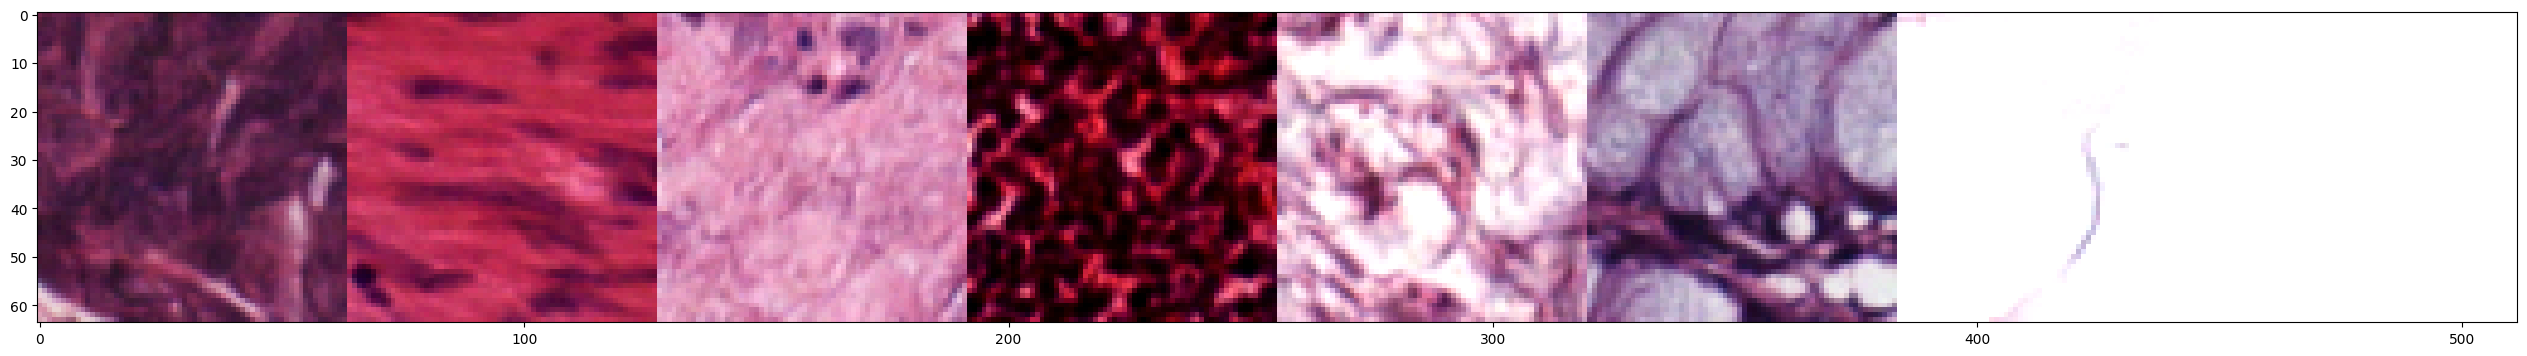

In [ ]:
diffusion = Diffusion(img_size=64, device=device)
sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
plot_images(sampled_images)

999it [03:51,  4.31it/s]


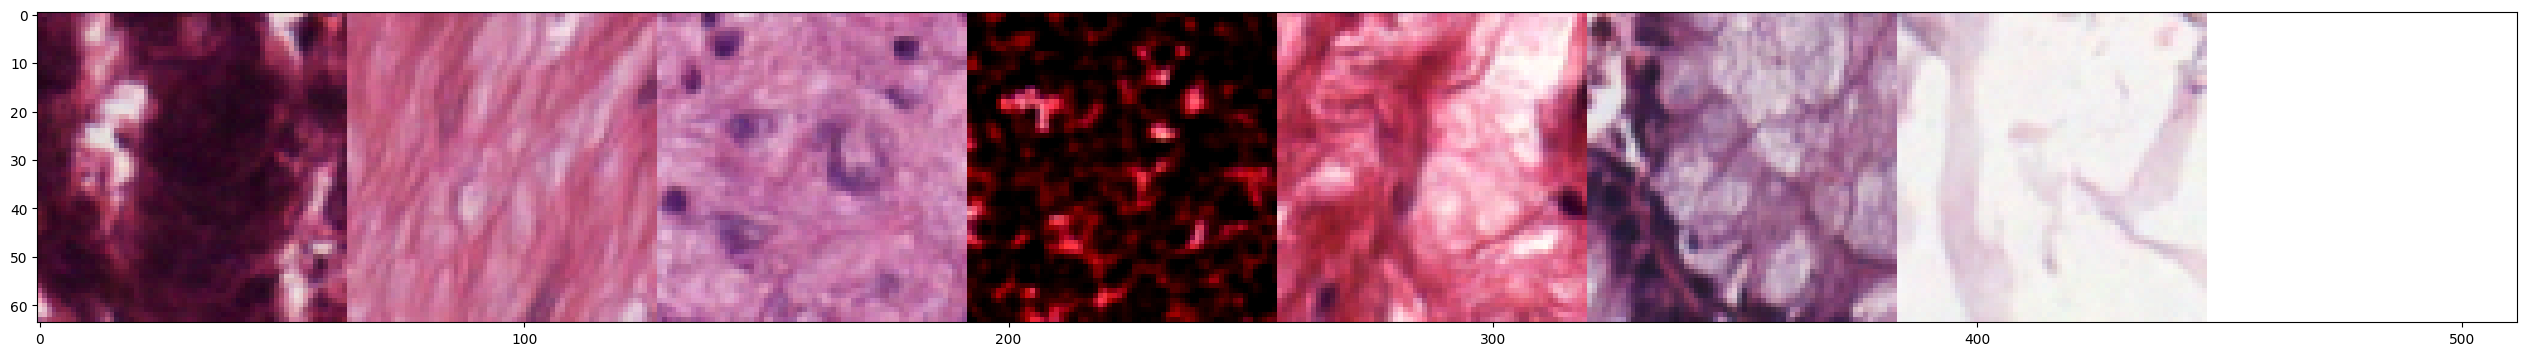

In [ ]:
sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
plot_images(sampled_images)

999it [03:52,  4.30it/s]


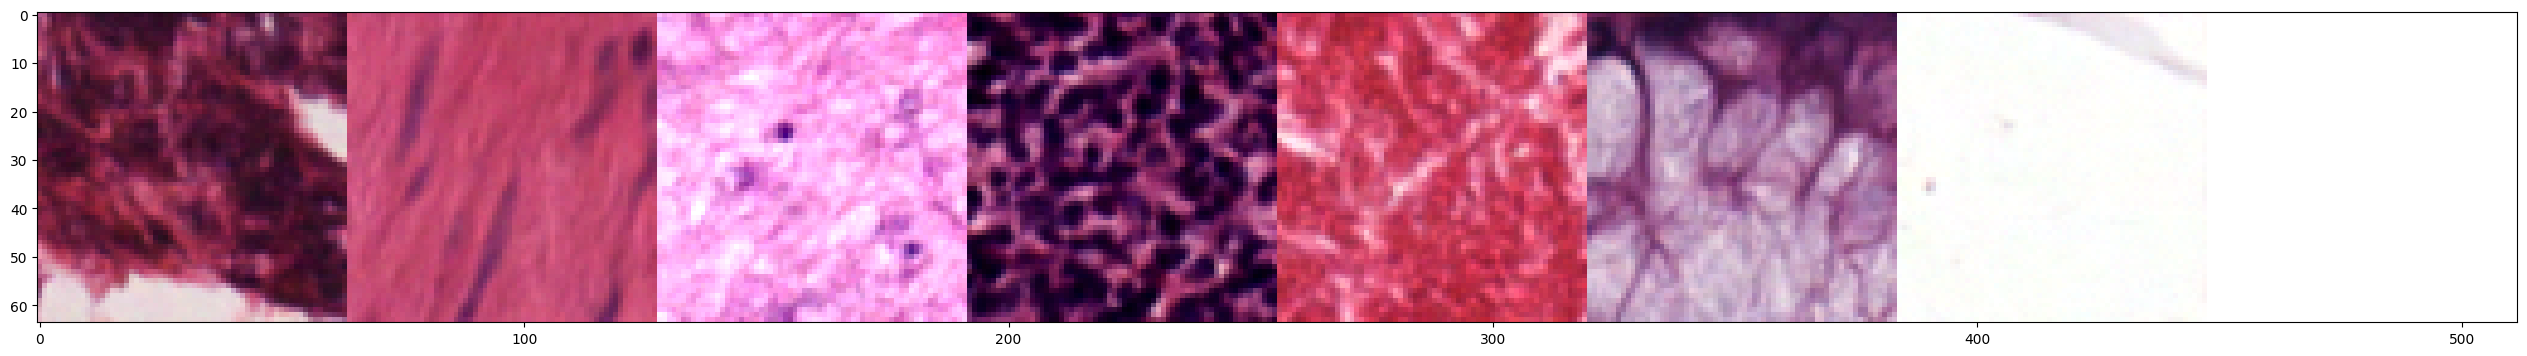

In [ ]:
sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
plot_images(sampled_images)

999it [03:56,  4.22it/s]


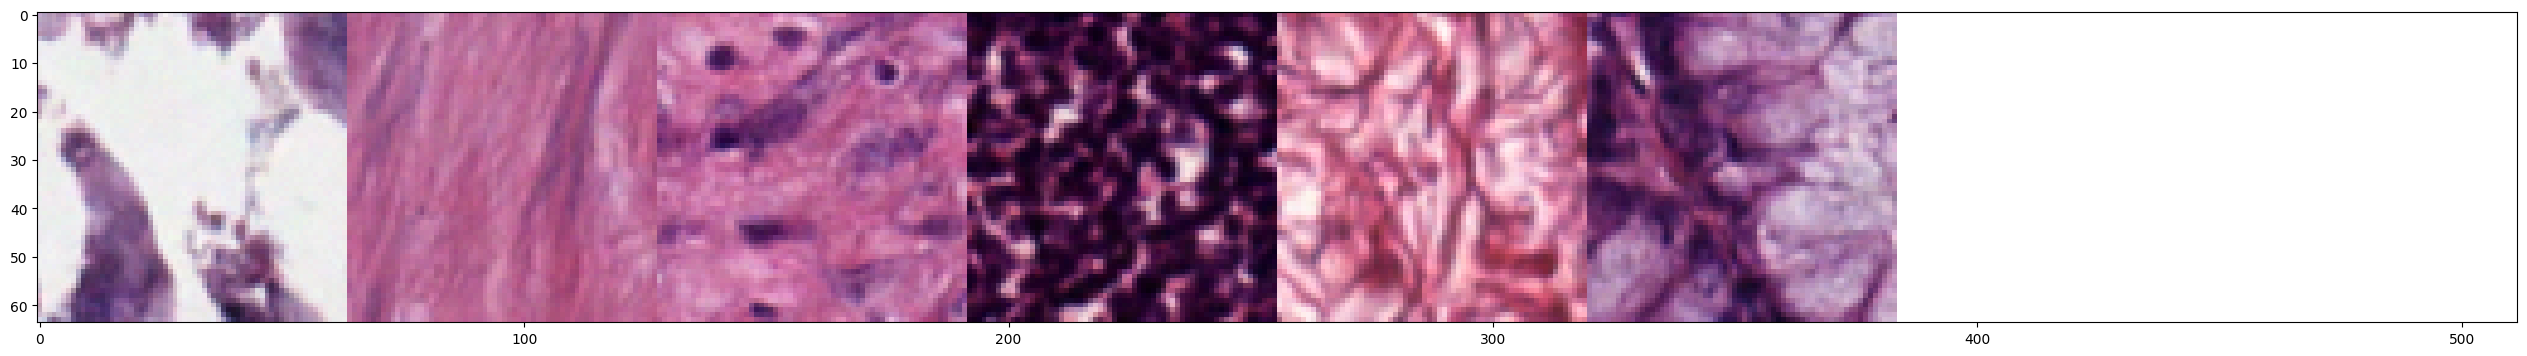

In [ ]:
diffusion = Diffusion(img_size_out=64, device=device)
sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
plot_images(sampled_images)

999it [03:52,  4.29it/s]


<class 'torch.Tensor'> torch.Size([8, 3, 128, 128])


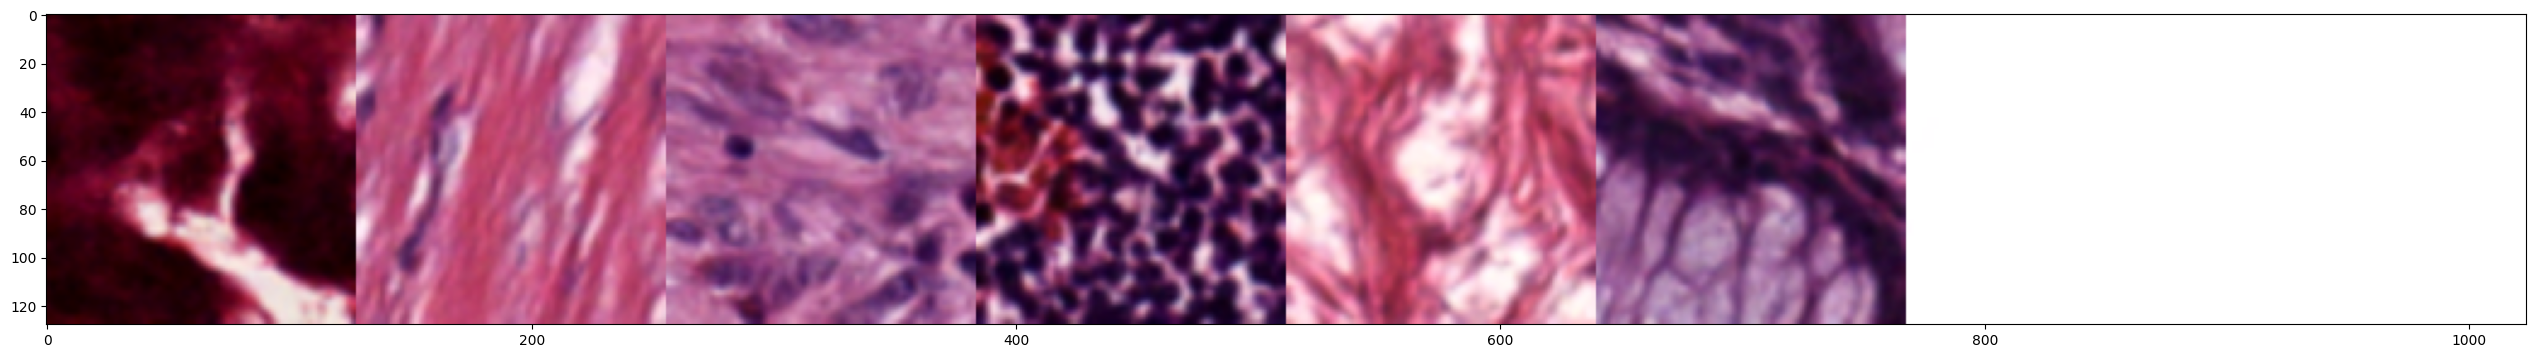

In [ ]:
diffusion = Diffusion(img_size_out=128, device=device)
sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
plot_images(sampled_images)

999it [03:58,  4.19it/s]


<class 'torch.Tensor'> torch.Size([8, 3, 256, 256])


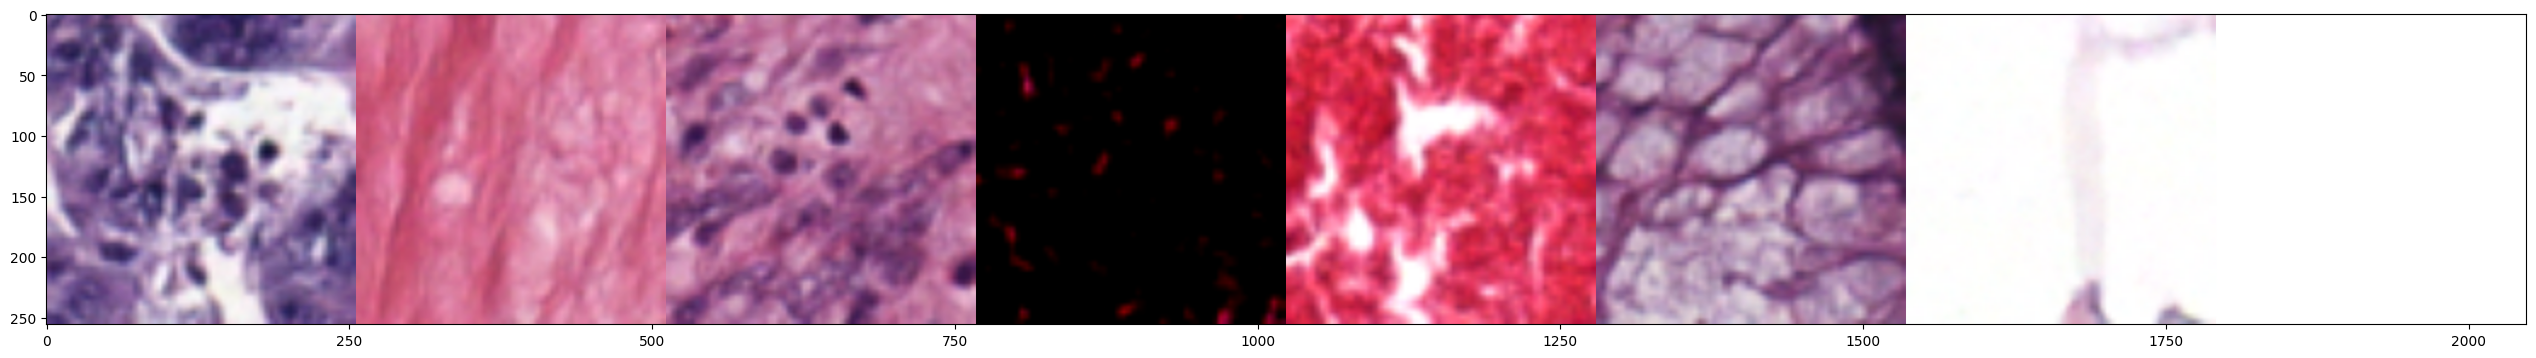

In [ ]:
diffusion = Diffusion(img_size_out=256, device=device)
sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
plot_images(sampled_images)

999it [04:06,  4.05it/s]


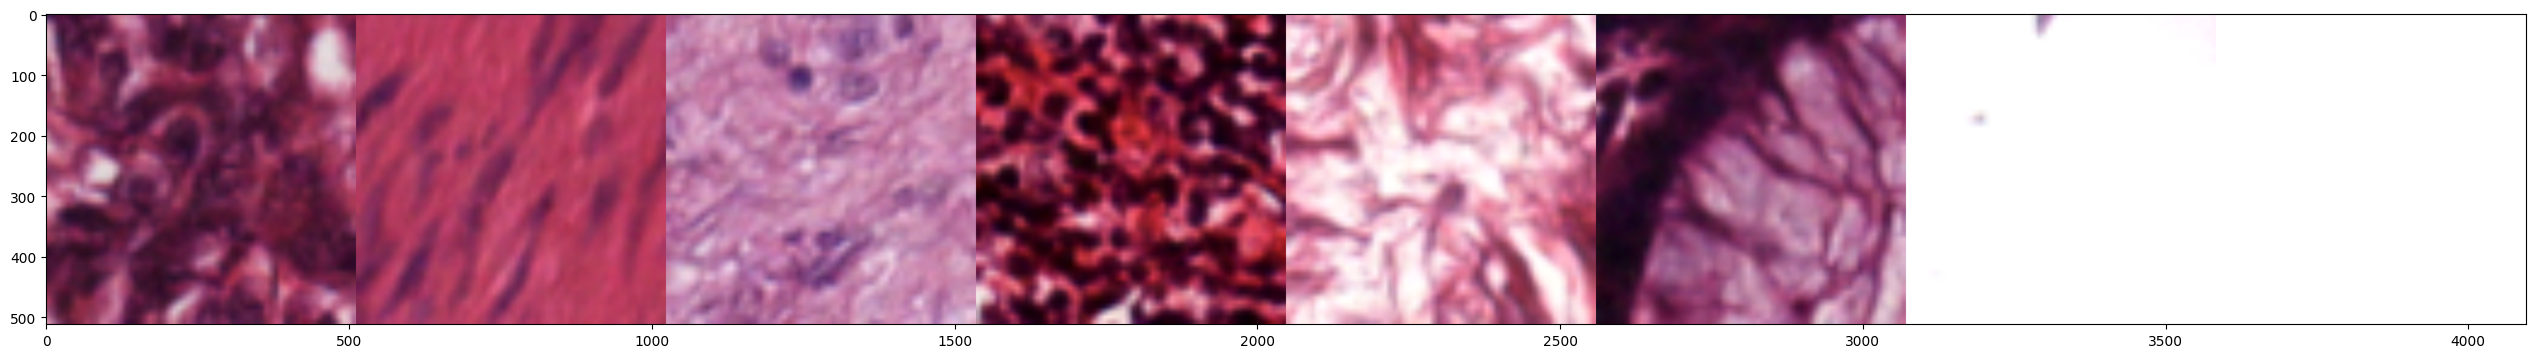

In [ ]:
diffusion = Diffusion(img_size_out=512, device=device)
sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
plot_images(sampled_images)